<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-1/blob/main/NesterovGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from random import randint
from random import random
from random import seed
import math
from sklearn.utils import shuffle

In [ ]:
from keras.datasets import fashion_mnist

In [ ]:
train_data,test_data=fashion_mnist.load_data()

In [ ]:
train_data_mean = np.mean(train_data[0])
train_data_stdev = np.std(train_data[0])
train_data = ((train_data[0] - train_data_mean) / train_data_stdev, train_data[1])
test_data = ((test_data[0] - train_data_mean) / train_data_stdev, test_data[1])
train_X, trainY = train_data
test_X, testY = test_data

In [ ]:
train_X, trainY = shuffle(train_X, trainY)
test_X, testY = shuffle(test_X, testY)

In [ ]:
print('Train: X=%s, y=%s' %(train_X.shape,trainY.shape))
print('Test: X=%s, y=%s' %(test_X.shape,testY.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [ ]:
trainX=[train_X[i].flatten() for i in range(len(train_X))]

In [ ]:
testX=[test_X[i].flatten() for i in range(len(test_X))]

In [ ]:
train_samples=len(trainX)
test_samples=len(testX)
xlen=len(trainX[0])
print(xlen)

784


In [ ]:
def initialize_weights(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[np.random.normal() for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[np.random.normal() for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[np.random.normal() for j in range(neurons_hl)]for i in range(n_output)])
    return W

In [ ]:
def initialize_bias(n_input, n_hidden_layer, n_output,neurons_hl):
    B=list()
    for i in range(n_hidden_layer):
        B.append([np.random.normal() for i in range(neurons_hl)])
    B.append([np.random.normal() for i in range(n_output)])
    return B

In [ ]:
def sigmoid(b):
  a=np.array(b,dtype=np.float128)
  h=list()
  for el in a:
    h.append(1/(1+np.exp(-el)))
  return h

In [ ]:
def softmax(b):
  a=np.array(b,dtype=np.float128)
  z = a - max(a)
  h=list()
  sum=0
  for el in z:
    sum+=np.exp(el)
  for el in z:
    h.append(np.exp(el)/sum)
  return h

In [ ]:
def feed_forward(input,W,B,L):
    H=list()
    A=list()
    H.append(input)
    A.append([0])
    for i in range(1,L):
        a=B[i-1]+np.matmul(W[i-1],H[i-1])
        A.append(a)
        H.append(sigmoid(a))
    a=B[L-1]+np.matmul(W[L-1],H[L-1])
    A.append(a)
    hL=softmax(a)
    H.append(hL)
    return H,A,hL

In [ ]:
def cmp(e):
  g=1/(1+np.exp(-e))
  return g*(1-g)

In [ ]:
def diff_sigmoid(a):
    res=list()
    for el in a:
      res.append(cmp(el))
    return res

In [ ]:
def back_propogation(H,A,y_hat,label,W,L,K):
    W_grad=list()
    B_grad=list()
    one_hot_y=np.zeros(K)
    one_hot_y[label]+=1
    ak_grad = y_hat-one_hot_y
    for k in range(L,0,-1):
        w_grad=np.matmul(np.matrix(ak_grad).T,np.matrix(H[k-1]))
        W_grad.append(w_grad)
        B_grad.append(ak_grad)
        if k != 1:
            h_grad=np.matmul(np.transpose(W[k-1]),ak_grad)
            ak_grad=np.multiply(h_grad,diff_sigmoid(A[k-1]))
    return W_grad,B_grad

In [ ]:
def nesterov():
    e,t=0,0
    L=3
    K=10
    N=8
    eta=0.001
    epoch=5
    batch_size=128
    W= initialize_weights(xlen,L-1,K,N)
    B= initialize_bias(xlen,L-1,K,N)
    loss=list()
    points=0
    error=0.0
    gamma=0.9
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    uw=list()
    ub=list()
    for l in range(L):
        uw.append(np.zeros(shape=np.shape(W[l])).tolist())
        ub.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (e<epoch):
        for i in range(train_samples):
            Wc=list()
            Bc=list()
            for l in range(L):
                Wc.append((W[l]-np.multiply(gamma,uw[l])).tolist())
                Bc.append((B[l]-np.multiply(gamma,ub[l])).tolist())
            H,A,y_hat=feed_forward(trainX[i],W,B,L)
            error+=(-math.log(y_hat[trainY[i]]))
            Hi,Ai,y_hati=feed_forward(trainX[i],Wc,Bc,L)
            W_grad,B_grad=back_propogation(Hi,Ai,y_hati,trainY[i],Wc,L,K)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                points=0
                t += 1
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    uw[l]=(np.multiply(gamma,uw[l])+np.multiply(eta,wgrad[l])).tolist()
                    W[l]=np.subtract(W[l],uw[l]).tolist()
                    ub[l]=(np.multiply(gamma,ub[l])+np.multiply(eta,bgrad[l])).tolist()
                    B[l]=np.subtract(B[l],ub[l]).tolist()
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())         
        e=e+1
        print('Epoch',e)
    return W,B,loss

In [ ]:
W_r,B_r,loss=nesterov()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


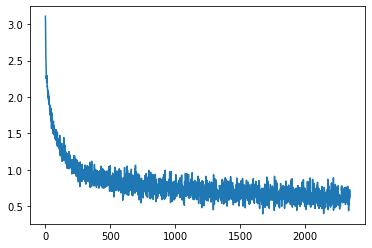

In [ ]:
plt.plot(np.arange(1,len(loss)+1),loss)

In [ ]:
#Prediction
valid=0
predict=[]
for i in range(test_samples):
    H,A,y_hat = feed_forward(testX[i],W_r,B_r,L=3)
    class_predict = y_hat.index(max(y_hat))
    predict.append(class_predict)
    if(class_predict==testY[i]):
      valid+=1
valid

7751